# Your First MLOps Pipeline

## Aim

> Build several common components found in MLOps pipelines to illustrate the essential concepts of MLOps.

This is by no means a comprehensive overview of all facets of MLOps, but it aims to illustrate a few of the important concepts.

## Outline
- What is MLOps?
- Turning the ML model training process into a pipeline
- Artefact and metadata tracking
  - Tensorboard demo
- Serving
  - APIs
- Drift
  - Data drift
  - Concept drift
- Monitoring
  - Visualising data drift
  - Logging user requests to visualise
- Alerting
  - Pagerduty example
- Retraining
  - Collecting more data to train on
  - Cron
  - Automatic retraining

## What is MLOps?

MLOps is shorthand for Machine Learning Operations. MLOps is to AI engineering what devops is to software engineering.

MLOps empowers organisations not just to deploy once, but to deploy over and over again quickly and efficiently by reducing the overhead and increasing automation that usually goes into maintaining machine learning systems in production.

## Why do we need MLOps?

- Serve more models
- Serve new versions of the same model

Why do we need new models?
- Unexpected performance differences between testing and production
- Evolving environments


### About the dataset

In this example, we're working with data from an online retailer, like Amazon, who make timely offers to their customers after every purchase. We want to build a machine learning model to determine the likelihood of a user claiming the offer so that we can confidently offer it to people who will take it. We don't want to offer it to everyone because it costs us to make the offer, which reduces our margins.

- Features:
    - `product_rating`: the difference between the average rating for that product and the user's rating
    - `delivery_duration`: the difference between the claimed delivery time and the actual delivery time
- Label:
    - `used_offer`: Whether the user claimed an offer shared with them after their successful delivery

However, we know that the distribution of data might change over time:
- Buyers may become more or less sensitive to product quality as supply changes
- Buyers may become more or less sensitive to delivery duration
- Buyers may change whether they claim the offer or not due to changes in the economy


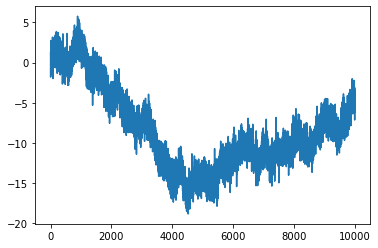

In [74]:
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

def sample_and_save_data():
    dataset = DriftingDataset(std=1)

    save = []
    datapoints = []
    for idx, example in enumerate(dataset):
        # turn example of (list, float) into a flat list
        save.append({"product_rating": example[0][0], "delivery_duration": example[0][1], "used_offer": example[1]})

        datapoints.append(example[0][0])
        if idx == 10000:
            break

    df = pd.DataFrame(save[:1000])


    # df.to_csv('data.csv', index=False)

    return datapoints

def plot_drifting_data(datapoints):   
    plt.plot(datapoints)
    plt.show()
    # save  the list called save as a csv file



data = sample_and_save_data()
plot_drifting_data(data)


In [75]:
import pandas as pd


def load_data():
    """Loads in the data, could be implemented differently to load in data from any source"""

    data = pd.read_csv(
        'data.csv')
    print(data.info())

    # ^^^ could read from database, filesystem storage, or other source in another application
    features = data.drop(columns=["used_offer"])
    labels = data["used_offer"]

    return features, labels


features, labels = load_data()

print(features.head())
print(labels.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_rating     1000 non-null   float64
 1   delivery_duration  1000 non-null   float64
 2   used_offer         1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB
None
   product_rating  delivery_duration
0        1.241197          -1.057440
1        0.782535           1.420452
2       -1.812189           1.679274
3        0.110688          -0.278303
4        0.172920          -1.148439
0    1
1    0
2    0
3    1
4    1
Name: used_offer, dtype: int64


## What goes into training a machine learning model?

You could fill a library with everything that I could mention here, but to summarise it, here are the key steps that go into training a ML model:
- Data preparation
- Model training
- Hyperparameter tuning
- Validation set evaluation
- Test set evaluation

The cells below illustrate what a simple version of this might look like.

In [77]:
# split
from sklearn.model_selection import train_test_split

def split_data(features, labels):
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=42) # split data into train and test data
    features_train, features_val, labels_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42) # split train data into train and validation data
    return features_train, features_test, features_val, labels_train, labels_test, labels_val

features_train, features_test, features_val, labels_train, labels_test, labels_val = split_data(features, labels)

Now let's train the model

In [79]:
from sklearn.tree import DecisionTreeClassifier

def train_model(features, labels):
    """Trains a model on the data"""

    model = DecisionTreeClassifier(
        criterion="entropy", max_depth=3, random_state=42, min_samples_leaf=5
    )
    model.fit(features, labels)

    return model

model = train_model(features_train, labels_train)

Next, we need to evaluate the performance of the model

In [81]:
# implement methods for the different parts of the pipeline, including hyperparameter tuning and evaluation

from sklearn.metrics import accuracy_score

def evaluate_model(model, X_test, y_test):
    """Evaluates the model on the test set"""

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

accuracy = evaluate_model(model, features_test, labels_test)

print(f"Accuracy: {accuracy}")



Accuracy: 0.955


Now create a function to save the model

In [ ]:
# save model
import joblib

def save_model(model):
    """Saves the model to disk"""

    joblib.dump(model, "model.joblib")

save_model(model)

Putting that all together...

In [ ]:

features, labels = load_data()
train_features, validation_features, test_features, train_labels, validation_labels, test_labels = split_data(features, labels)
model = train_model(train_features, train_labels)
accuracy = evaluate_model(model, test_features, test_labels)
print(f"Accuracy: {accuracy}")


### Pipelining the ML training process

Imagine you're a data scientist who's developed a machine learning model. You've found out how to create a model that works by setting the right model configuration and processing the data correctly. However, you know that in the future your data is going to change, because you know that over time, the inputs will change with trends. That means you're going to train this model more than once, which is why it's useful to keep this code for re-use.

Now, we can put that all into a function that trains the model from end to end.

In [ ]:
def train_and_evaluate_model(features, labels):
    features, labels = load_data()
    train_features, validation_features, test_features, train_labels, validation_labels, test_labels = split_data(features, labels)
    model = train_model(train_features, train_labels)
    accuracy = evaluate_model(model, test_features, test_labels)
    print(f"Accuracy: {accuracy}")


## Drift - Is my problem changing over time?

Run the cell below to define an object that simulates the data changing over time

In [ ]:

import numpy as np
import pandas as pd
import time


class DriftingDataset:
    def __init__(
        self,
        mean=0,
        std=1,
        data_drift="linear",
        concept_drift="linear",
    ):
        self.mean = mean
        self.std = std
        self.n_features = 2
        self.mapping_weight = np.random.uniform()
        self.mapping_bias = np.random.uniform()
        # self.drift_pattern = "linear"
        # self.drift_idx = 0

    def mapping(self, x):
        z = (x[0] - x[1]) #* self.mapping_weight #+ self.mapping_bias
        ex = 0 if z < 0 else 1
        return ex

    def generate_datapoint(self):
        x = np.random.normal(self.mean, self.std, self.n_features)
        return x, self.mapping(x)

    def increase_data_drift(self):
        self.mean += np.random.normal(0, 0.1, self.n_features)
        # self.std += 0.1
        # self.drift_idx += 1

    # def increase_concept_drift(self):
    #     self.mapping_weights += 1
    #     self.mapping_bias += 1
    #     self.concept_drift_idx += 1

    def __iter__(self):
        def _():
            while True:
                yield self.generate_datapoint()
                self.increase_data_drift()
        return _()


# if __name__ == "__main__":

#     dataset = DriftingDataset()

#     for example in dataset:
#         print(example)
#         time.sleep(1)
